# Bag-of-Words based Natural Language Inference

A Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.


In [1]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from collections import Counter

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt 

In [2]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

---
### 1 Dataset 
#### Data Processing

In [4]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

**Coding 1: finish `build_vocab` function** 


In [5]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
    
    flat_hypo_tokens = [item for sublist in hypo_tokens for item in sublist]
    flat_prem_tokens = [item for sublist in prem_tokens for item in sublist]
    
    counter_hypo_tokens = Counter(flat_hypo_tokens)
    counter_prem_tokens = Counter(flat_prem_tokens)
    counter_all_tokens = counter_hypo_tokens + counter_prem_tokens
    
    vocab, count = zip(*counter_all_tokens.most_common(max_vocab_size))
    vocab_freq = zip(vocab, range(2, 2 + len(vocab)))
    
    id2token = ['<pad>', '<unk>'] + list(vocab)

    token2id = dict(vocab_freq)
    token2id['<unk>'] = UNK_IDX
    token2id['<pad>'] = PAD_IDX
    
    return token2id, id2token

**Coding 2: finish `token2index` function** 

In [6]:
def token2index(tokens_data, token2id):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    
    indices_data = []
    for tokens in tokens_data:
        index_list = []
        for token in tokens:
            if token in token2id:
                index_list.append(token2id[token])
            else:
                index_list.append(UNK_IDX)                
        indices_data.append(index_list)
    return indices_data

In [7]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)
hypo_data_indices_train = token2index(hypo_data_tokens_train, token2id)
prem_data_indices_train = token2index(prem_data_tokens_train, token2id)
hypo_data_indices_val = token2index(hypo_data_tokens_val, token2id)
prem_data_indices_val= token2index(prem_data_tokens_val, token2id)

#### DataLoader

**Coding 3: finish DataLoader** 

In [8]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=0)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=0)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [9]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [10]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [11]:
# TODO:
# finish DataLoader
BATCH_SIZE = 1024
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, collate_fn=newsgroup_collate_func)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, collate_fn=newsgroup_collate_func)

---
### 2 Model 

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (code from the labs may be helpful). 

In [12]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        # 1. Embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # 2. Linear Layers
        if reduce == 'concat':
            emb_dim = 2 * emb_dim
        
        self.linear = nn.Linear(emb_dim, n_out)
        

    def forward(self, data_hypo, length_hypo, data_prem, length_prem, reduce):
        """
        @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents a
        review that is represented using n-gram index. Note that they are padded to have same length.
        @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
        length of each sentences in data_hypo.
        @param data_prem: matrix of size (batch_size, max_sentence_length).
        @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in data_prem.
        @param reduce: interaction type: [sum, concat, element-wise].
        """

        # TODO:
        # word embedding
        embed_hypo = self.embedding(data_hypo)
        embed_prem = self.embedding(data_prem)
        # combine to sentence
        embed_prem = torch.sum(embed_prem, dim=1)
        embed_hypo = torch.sum(embed_hypo, dim=1)
        length_prem_size = length_prem.view(length_prem.size()[0], 1)
        length_prem_size = length_prem_size.expand_as(embed_prem)
        length_prem_size = length_prem_size.float()
        length_hypo_size = length_hypo.view(length_hypo.size()[0], 1)
        length_hypo_size = length_hypo_size.expand_as(embed_hypo)
        length_hypo_size = length_hypo_size.float()
        embed_prem = embed_prem / length_prem_size
        embed_hypo = embed_hypo / length_hypo_size
    
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if reduce == 'concat':
            x = torch.cat((embed_hypo, embed_prem), 1)
        if reduce == 'sum':
            x = torch.add(embed_hypo, embed_prem)
        if reduce == 'hadamard':
            x = torch.mul(embed_hypo, embed_prem)

        # hidden layers 
        out = self.linear(x)

        return out

---
### 3 Training and Validation

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [13]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 50
# 3. reduce : ["sum", "hadamard", "concat"]
reduce = "concat"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 10
BATCH_SIZE = 1024

In [14]:
model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


**Coding 5: finish training and validation** 

The following incomplete code can get you started on your train loop. Feel free to modify the function signature to pass any arguments needed for the training.

In [15]:
def model_test(data_loader, model, reduce):
    total = 0
    correct = 0
    for ii, current_data in enumerate(data_loader):
        data_hypo, lengths_hypo, data_prem, lengths_prem, labels = current_data
        data_hypo, lengths_hypo = data_hypo, lengths_hypo
        data_prem, lengths_prem = data_prem, lengths_prem 
        labels = labels
        out = model(data_hypo, lengths_hypo, data_prem, lengths_prem, reduce)
        loss = criterion(out, labels)
        preds = out.max(1, keepdim=True)[1]
        total = total + labels.size(0)
        true_list = labels.view_as(preds) == preds
        true_count = sum(true_list).item()
        correct = correct + true_count
    accuracy = (correct / total) * 100
    loss = loss.item()
    return accuracy, loss

In [16]:
# training:
def train(model, criterion, optimizer, reduce):
    model
    train_losses = [] # record training loss after every epoch
    val_losses = [] # record validation loss after every epoch
    train_accs = [] # record training accuracy after every epoch
    val_accs = [] # record validation accuracy after every epoch

    train_losses_batch = [] # record training loss after every batch
    val_losses_batch = [] # record validation loss after every batch
    train_accs_batch = [] # record training accuracy after every batch
    val_accs_batch = [] # record validation accuracy after every batch
    
    for epoch in range(num_epochs):
        current_loss_train = 0.0
        current_acc_train = 0.0
        current_loss_val = 0.0
        current_acc_val = 0.0
        
        for ii, current_data in enumerate(train_dataloader):
            data_hypo, lengths_hypo, data_prem, lengths_prem, labels = current_data
            data_hypo, lengths_hypo = data_hypo, lengths_hypo
            data_prem, lengths_prem = data_prem, lengths_prem 
            labels = labels
            model.train()
            optimizer.zero_grad()
            out = model(data_hypo,lengths_hypo, data_prem, lengths_prem, reduce)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
            train_acc, train_loss = model_test(train_dataloader, model, reduce)
            val_acc, val_loss = model_test(val_dataloader, model, reduce)
            val_accs_batch.append(val_acc)
            val_losses_batch.append(val_loss)
            train_accs_batch.append(train_acc)
            train_losses_batch.append(train_loss)
            current_loss_train = current_loss_train + train_loss
            current_loss_val = current_loss_val + val_loss
            current_acc_train = current_acc_train + train_acc
            current_acc_val = current_acc_val + val_acc
            
            print('Finish epoch: ', epoch, ' batch: ', ii)

        train_acc = current_acc_train/len(train_dataloader)
        train_loss = current_loss_train/len(train_dataloader)
        val_acc = current_acc_val/len(train_dataloader)
        val_loss = current_loss_val/len(train_dataloader)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

    result = {'batch': {'train_losses': train_losses_batch, 'val_losses': val_losses_batch, 'train_accs': train_accs_batch, 'val_accs': val_accs_batch}, 
              'epoch': {'train_losses': train_losses, 'val_losses': val_losses, 'train_accs': train_accs,  'val_accs': val_accs}}
              
    return result

In [17]:
# ensure reproducibility
torch.manual_seed(2022)
np.random.seed(2022)
torch.cuda.manual_seed(2022)

##### Hyperparameter Tuning

In [18]:
max_vocab_size = 10000
emb_dim = 50
reduce = "concat"

num_epochs = 10
BATCH_SIZE = 1024

In [19]:
lr_list = [0.1, 0.05, 0.01, 0.005]
lr_str_list = ['1e-1', '5e-2', '1e-2', '5e-3']
reduce_list = ['hadamard', 'concat']

In [20]:
for ii in range(4):
    for kk in range(2):
        print(f'Model  Reduce={reduce_list[kk]}  lr={lr_str_list[ii]}\n')
        model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce_list[kk])
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr_list[ii])
        result = train(model, criterion, optimizer, reduce=reduce_list[kk])
        
        f = open(f'result_{reduce_list[kk]}_embed50_lr{lr_str_list[ii]}.pkl', 'wb')
        pkl.dump(result, f)
        f.close()
        
        torch.save(model, f'model_{reduce_list[kk]}_embed50_lr{lr_str_list[ii]}.out')
        print('\n')

Model  Reduce=hadamard  lr=1e-1

Finish epoch:  0  batch:  0
Finish epoch:  0  batch:  1
Finish epoch:  0  batch:  2
Finish epoch:  0  batch:  3
Finish epoch:  0  batch:  4
Finish epoch:  0  batch:  5
Finish epoch:  0  batch:  6
Finish epoch:  0  batch:  7
Finish epoch:  0  batch:  8
Finish epoch:  0  batch:  9
Finish epoch:  0  batch:  10
Finish epoch:  0  batch:  11
Finish epoch:  0  batch:  12
Finish epoch:  0  batch:  13
Finish epoch:  0  batch:  14
Finish epoch:  0  batch:  15
Finish epoch:  0  batch:  16
Finish epoch:  0  batch:  17
Finish epoch:  0  batch:  18
Finish epoch:  0  batch:  19
Finish epoch:  0  batch:  20
Finish epoch:  0  batch:  21
Finish epoch:  0  batch:  22
Finish epoch:  0  batch:  23
Finish epoch:  0  batch:  24
Finish epoch:  0  batch:  25
Finish epoch:  0  batch:  26
Finish epoch:  0  batch:  27
Finish epoch:  0  batch:  28
Finish epoch:  0  batch:  29
Finish epoch:  0  batch:  30
Finish epoch:  0  batch:  31
Finish epoch:  0  batch:  32
Finish epoch:  0  ba

Finish epoch:  4  batch:  0
Finish epoch:  4  batch:  1
Finish epoch:  4  batch:  2
Finish epoch:  4  batch:  3
Finish epoch:  4  batch:  4
Finish epoch:  4  batch:  5
Finish epoch:  4  batch:  6
Finish epoch:  4  batch:  7
Finish epoch:  4  batch:  8
Finish epoch:  4  batch:  9
Finish epoch:  4  batch:  10
Finish epoch:  4  batch:  11
Finish epoch:  4  batch:  12
Finish epoch:  4  batch:  13
Finish epoch:  4  batch:  14
Finish epoch:  4  batch:  15
Finish epoch:  4  batch:  16
Finish epoch:  4  batch:  17
Finish epoch:  4  batch:  18
Finish epoch:  4  batch:  19
Finish epoch:  4  batch:  20
Finish epoch:  4  batch:  21
Finish epoch:  4  batch:  22
Finish epoch:  4  batch:  23
Finish epoch:  4  batch:  24
Finish epoch:  4  batch:  25
Finish epoch:  4  batch:  26
Finish epoch:  4  batch:  27
Finish epoch:  4  batch:  28
Finish epoch:  4  batch:  29
Finish epoch:  4  batch:  30
Finish epoch:  4  batch:  31
Finish epoch:  4  batch:  32
Finish epoch:  4  batch:  33
Finish epoch:  4  batch:

Finish epoch:  4  batch:  17
Finish epoch:  4  batch:  18
Finish epoch:  4  batch:  19
Finish epoch:  4  batch:  20
Finish epoch:  4  batch:  21
Finish epoch:  4  batch:  22
Finish epoch:  4  batch:  23
Finish epoch:  4  batch:  24
Finish epoch:  4  batch:  25
Finish epoch:  4  batch:  26
Finish epoch:  4  batch:  27
Finish epoch:  4  batch:  28
Finish epoch:  4  batch:  29
Finish epoch:  4  batch:  30
Finish epoch:  4  batch:  31
Finish epoch:  4  batch:  32
Finish epoch:  4  batch:  33
Finish epoch:  4  batch:  34
Finish epoch:  4  batch:  35
Finish epoch:  4  batch:  36
Finish epoch:  4  batch:  37
Finish epoch:  4  batch:  38
Finish epoch:  4  batch:  39
Finish epoch:  4  batch:  40
Finish epoch:  4  batch:  41
Finish epoch:  4  batch:  42
Finish epoch:  4  batch:  43
Finish epoch:  4  batch:  44
Finish epoch:  4  batch:  45
Finish epoch:  4  batch:  46
Finish epoch:  4  batch:  47
Finish epoch:  4  batch:  48
Finish epoch:  4  batch:  49
Finish epoch:  4  batch:  50
Finish epoch: 

Finish epoch:  4  batch:  35
Finish epoch:  4  batch:  36
Finish epoch:  4  batch:  37
Finish epoch:  4  batch:  38
Finish epoch:  4  batch:  39
Finish epoch:  4  batch:  40
Finish epoch:  4  batch:  41
Finish epoch:  4  batch:  42
Finish epoch:  4  batch:  43
Finish epoch:  4  batch:  44
Finish epoch:  4  batch:  45
Finish epoch:  4  batch:  46
Finish epoch:  4  batch:  47
Finish epoch:  4  batch:  48
Finish epoch:  4  batch:  49
Finish epoch:  4  batch:  50
Finish epoch:  4  batch:  51
Finish epoch:  4  batch:  52
Finish epoch:  4  batch:  53
Finish epoch:  4  batch:  54
Finish epoch:  4  batch:  55
Finish epoch:  4  batch:  56
Finish epoch:  4  batch:  57
Finish epoch:  4  batch:  58
Finish epoch:  4  batch:  59
Finish epoch:  4  batch:  60
Finish epoch:  4  batch:  61
Finish epoch:  4  batch:  62
Finish epoch:  4  batch:  63
Finish epoch:  4  batch:  64
Finish epoch:  4  batch:  65
Finish epoch:  4  batch:  66
Finish epoch:  4  batch:  67
Finish epoch:  4  batch:  68
Finish epoch: 

Finish epoch:  4  batch:  52
Finish epoch:  4  batch:  53
Finish epoch:  4  batch:  54
Finish epoch:  4  batch:  55
Finish epoch:  4  batch:  56
Finish epoch:  4  batch:  57
Finish epoch:  4  batch:  58
Finish epoch:  4  batch:  59
Finish epoch:  4  batch:  60
Finish epoch:  4  batch:  61
Finish epoch:  4  batch:  62
Finish epoch:  4  batch:  63
Finish epoch:  4  batch:  64
Finish epoch:  4  batch:  65
Finish epoch:  4  batch:  66
Finish epoch:  4  batch:  67
Finish epoch:  4  batch:  68
Finish epoch:  4  batch:  69
Finish epoch:  4  batch:  70
Finish epoch:  4  batch:  71
Finish epoch:  4  batch:  72
Finish epoch:  4  batch:  73
Finish epoch:  4  batch:  74
Finish epoch:  4  batch:  75
Finish epoch:  4  batch:  76
Finish epoch:  4  batch:  77
Finish epoch:  4  batch:  78
Finish epoch:  4  batch:  79
Finish epoch:  4  batch:  80
Finish epoch:  4  batch:  81
Finish epoch:  4  batch:  82
Finish epoch:  4  batch:  83
Finish epoch:  4  batch:  84
Finish epoch:  4  batch:  85
Finish epoch: 

Finish epoch:  8  batch:  21
Finish epoch:  8  batch:  22
Finish epoch:  8  batch:  23
Finish epoch:  8  batch:  24
Finish epoch:  8  batch:  25
Finish epoch:  8  batch:  26
Finish epoch:  8  batch:  27
Finish epoch:  8  batch:  28
Finish epoch:  8  batch:  29
Finish epoch:  8  batch:  30
Finish epoch:  8  batch:  31
Finish epoch:  8  batch:  32
Finish epoch:  8  batch:  33
Finish epoch:  8  batch:  34
Finish epoch:  8  batch:  35
Finish epoch:  8  batch:  36
Finish epoch:  8  batch:  37
Finish epoch:  8  batch:  38
Finish epoch:  8  batch:  39
Finish epoch:  8  batch:  40
Finish epoch:  8  batch:  41
Finish epoch:  8  batch:  42
Finish epoch:  8  batch:  43
Finish epoch:  8  batch:  44
Finish epoch:  8  batch:  45
Finish epoch:  8  batch:  46
Finish epoch:  8  batch:  47
Finish epoch:  8  batch:  48
Finish epoch:  8  batch:  49
Finish epoch:  8  batch:  50
Finish epoch:  8  batch:  51
Finish epoch:  8  batch:  52
Finish epoch:  8  batch:  53
Finish epoch:  8  batch:  54
Finish epoch: 

Finish epoch:  4  batch:  87
Finish epoch:  4  batch:  88
Finish epoch:  4  batch:  89
Finish epoch:  4  batch:  90
Finish epoch:  4  batch:  91
Finish epoch:  4  batch:  92
Finish epoch:  4  batch:  93
Finish epoch:  4  batch:  94
Finish epoch:  4  batch:  95
Finish epoch:  4  batch:  96
Finish epoch:  4  batch:  97
Finish epoch:  5  batch:  0
Finish epoch:  5  batch:  1
Finish epoch:  5  batch:  2
Finish epoch:  5  batch:  3
Finish epoch:  5  batch:  4
Finish epoch:  5  batch:  5
Finish epoch:  5  batch:  6
Finish epoch:  5  batch:  7
Finish epoch:  5  batch:  8
Finish epoch:  5  batch:  9
Finish epoch:  5  batch:  10
Finish epoch:  5  batch:  11
Finish epoch:  5  batch:  12
Finish epoch:  5  batch:  13
Finish epoch:  5  batch:  14
Finish epoch:  5  batch:  15
Finish epoch:  5  batch:  16
Finish epoch:  5  batch:  17
Finish epoch:  5  batch:  18
Finish epoch:  5  batch:  19
Finish epoch:  5  batch:  20
Finish epoch:  5  batch:  21
Finish epoch:  5  batch:  22
Finish epoch:  5  batch:

Finish epoch:  5  batch:  7
Finish epoch:  5  batch:  8
Finish epoch:  5  batch:  9
Finish epoch:  5  batch:  10
Finish epoch:  5  batch:  11
Finish epoch:  5  batch:  12
Finish epoch:  5  batch:  13
Finish epoch:  5  batch:  14
Finish epoch:  5  batch:  15
Finish epoch:  5  batch:  16
Finish epoch:  5  batch:  17
Finish epoch:  5  batch:  18
Finish epoch:  5  batch:  19
Finish epoch:  5  batch:  20
Finish epoch:  5  batch:  21
Finish epoch:  5  batch:  22
Finish epoch:  5  batch:  23
Finish epoch:  5  batch:  24
Finish epoch:  5  batch:  25
Finish epoch:  5  batch:  26
Finish epoch:  5  batch:  27
Finish epoch:  5  batch:  28
Finish epoch:  5  batch:  29
Finish epoch:  5  batch:  30
Finish epoch:  5  batch:  31
Finish epoch:  5  batch:  32
Finish epoch:  5  batch:  33
Finish epoch:  5  batch:  34
Finish epoch:  5  batch:  35
Finish epoch:  5  batch:  36
Finish epoch:  5  batch:  37
Finish epoch:  5  batch:  38
Finish epoch:  5  batch:  39
Finish epoch:  5  batch:  40
Finish epoch:  5 

#### Performance variation based on hyper-parameter values

**Written 1:** 
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
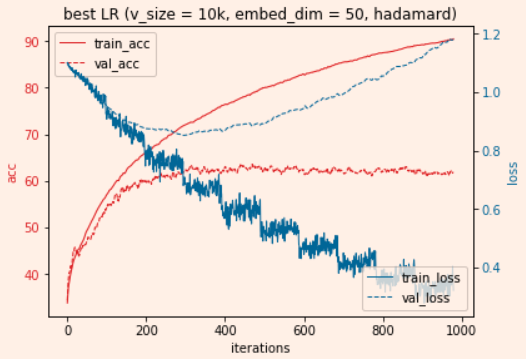

The following function may be useful to you to accomplish this, but you are also welcome to modify it or write your own plotting code.

In [21]:
def plot_over_training(per_epoch_metrics, title_name):
  """Utility function to plot train/val accuracies and losses.

  @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
  @param title_name: String to show on the plot title.
  """
  t = np.arange(0, len(per_epoch_metrics['train_accs']))
  train_acc = per_epoch_metrics['train_accs']
  val_acc = per_epoch_metrics['val_accs']
  train_loss = per_epoch_metrics['train_losses']
  val_loss = per_epoch_metrics['val_losses']

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('acc', color=color)
  ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
  ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper left')
  ax2 = ax1.twinx() 

  color = 'tab:blue'
  ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
  ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
  ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.legend(loc='lower right')
  fig.tight_layout() 
  plt.title(title_name)
  plt.show()

In [22]:
f = open('result_concat_embed50_lr1e-1.pkl', 'rb')
result_model_concat_1 = pkl.load(f)
f.close()
f = open('result_concat_embed50_lr5e-2.pkl', 'rb')
result_model_concat_2 = pkl.load(f)
f.close()
f = open('result_concat_embed50_lr1e-2.pkl', 'rb')
result_model_concat_3 = pkl.load(f)
f.close()
f = open('result_concat_embed50_lr5e-3.pkl', 'rb')
result_model_concat_4 = pkl.load(f)
f.close()
f = open('result_hadamard_embed50_lr1e-1.pkl', 'rb')
result_model_hadamard_1 = pkl.load(f)
f.close()
f = open('result_hadamard_embed50_lr5e-2.pkl', 'rb')
result_model_hadamard_2 = pkl.load(f)
f.close()
f = open('result_hadamard_embed50_lr1e-2.pkl', 'rb')
result_model_hadamard_3 = pkl.load(f)
f.close()
f = open('result_hadamard_embed50_lr5e-3.pkl', 'rb')
result_model_hadamard_4 = pkl.load(f)
f.close()

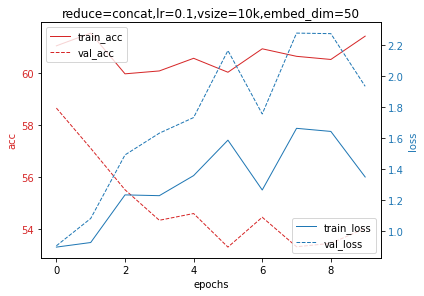

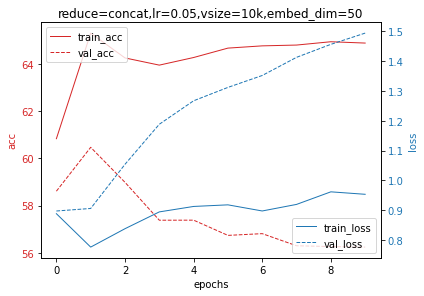

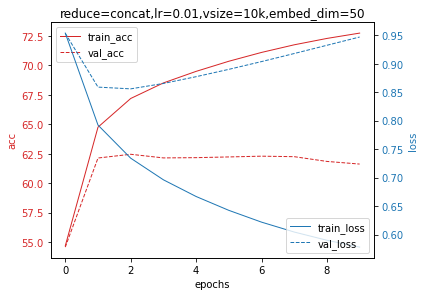

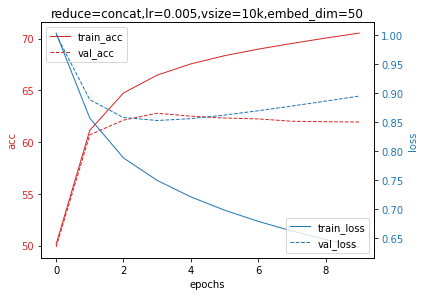

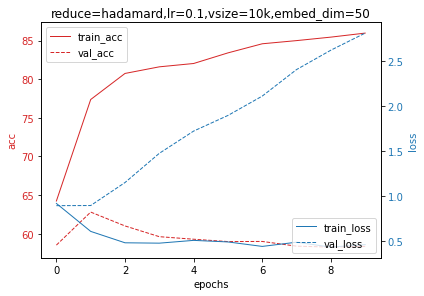

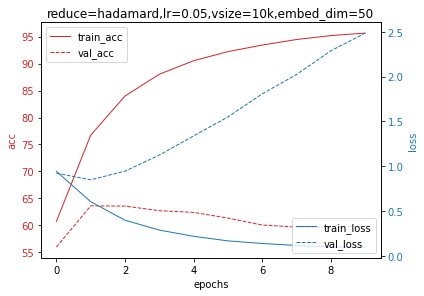

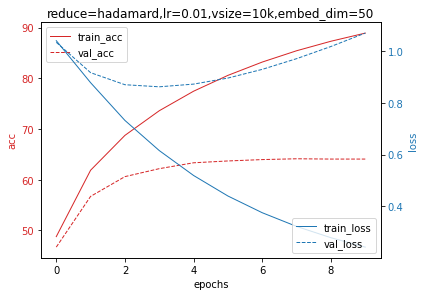

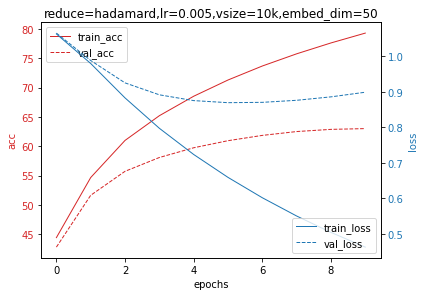

In [23]:
plot_over_training(result_model_concat_1['epoch'],'reduce=concat,lr=0.1,vsize=10k,embed_dim=50')
plot_over_training(result_model_concat_2['epoch'],'reduce=concat,lr=0.05,vsize=10k,embed_dim=50')
plot_over_training(result_model_concat_3['epoch'],'reduce=concat,lr=0.01,vsize=10k,embed_dim=50')
plot_over_training(result_model_concat_4['epoch'],'reduce=concat,lr=0.005,vsize=10k,embed_dim=50')
plot_over_training(result_model_hadamard_1['epoch'],'reduce=hadamard,lr=0.1,vsize=10k,embed_dim=50')
plot_over_training(result_model_hadamard_2['epoch'],'reduce=hadamard,lr=0.05,vsize=10k,embed_dim=50')
plot_over_training(result_model_hadamard_3['epoch'],'reduce=hadamard,lr=0.01,vsize=10k,embed_dim=50')
plot_over_training(result_model_hadamard_4['epoch'],'reduce=hadamard,lr=0.005,vsize=10k,embed_dim=50')

In [24]:
hyper_acc_maxes = [max(result_model_concat_1['epoch']['val_accs']),
                   max(result_model_concat_2['epoch']['val_accs']),
                   max(result_model_concat_3['epoch']['val_accs']),
                   max(result_model_concat_4['epoch']['val_accs']),
                   max(result_model_hadamard_1['epoch']['val_accs']),
                   max(result_model_hadamard_2['epoch']['val_accs']),
                   max(result_model_hadamard_3['epoch']['val_accs']),
                   max(result_model_hadamard_4['epoch']['val_accs']),]

In [25]:
hyper_acc_maxes

[58.6428571428571,
 60.470408163265326,
 62.45408163265305,
 62.786734693877534,
 62.79999999999999,
 63.626530612244906,
 64.13571428571433,
 63.020408163265266]

In [26]:
print('Best Model Index: ', hyper_acc_maxes.index(max(hyper_acc_maxes)))

Best Model Index:  6


**Written 2:** 
Take your best model based on validation performace and report its validation accuracy:

``After testing out 'hadamard' and 'concat' and learning rate = [0.1, 0.05, 0.01, 0.005]``

``The Best Model is the one with reduce=hadamard, and learning_rate=0.01``

``The validation accuracy is 64.13``

Hyperparameters
- max_vocab_size = 10000
- emb_dim = 50
- reduce = "hadamard"
- learning_rate=0.01
- BATCH_SIZE = 1024
- num_epochs = 10

**Written 3:** 

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [27]:
reduce = 'hadamard'
model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
model = torch.load('model_hadamard_embed50_lr1e-2.out')

In [28]:
# obtain true and false predictions
for ii, current_data in enumerate(val_dataloader):
    data_hypo, lengths_hypo, data_prem, lengths_prem, labels = current_data
    out = model(data_hypo, lengths_hypo, data_prem, lengths_prem, reduce)
    loss = criterion(out, labels)
    preds = out.max(1, keepdim=True)[1]
    true_list = labels.view_as(preds) == preds

# obtain indices for statements
correct_indices = []
incorrect_indices = []
ii = 0
for ele in true_list:
    if ele[0] == False:
        incorrect_indices.append(ii)
    if ele[0] == True:
        correct_indices.append(ii)
    if len(correct_indices) >= 3 and len(incorrect_indices) >= 3:
        break
    ii += 1
correct_indices = correct_indices[:3]
incorrect_indices = incorrect_indices[:3]

In [29]:
lbls = {0:'neutral' , 1:'entailment', 2:'contradiction'}

In [30]:
# three correct ones
for ii in correct_indices:
    print('Index: ', ii)
    
    hypothesis = [id2token[x] for x in data_hypo[ii][:lengths_hypo[ii]]]
    hypothesis = ' '.join(hypothesis)
    print('Hypothesis:', hypothesis)

    premise = [id2token[x] for x in data_prem[ii][:lengths_prem[ii]]]
    premise = ' '.join(premise)
    print('Premise:' , premise)

    print('Label:', lbls[labels[ii].item()])
    print('Prediction:', lbls[preds[ii].item()])
    print('\n')

Index:  0
Hypothesis: three women on a stage one wearing red shoes black pants and a gray shirt is sitting on a prop
Premise: there are two women standing on the stage
Label: contradiction
Prediction: contradiction


Index:  1
Hypothesis: four people sit on a subway two read books one looks at a cellphone and is wearing knee high boots
Premise: multiple people are on a subway together with each of them doing their own thing
Label: entailment
Prediction: entailment


Index:  2
Hypothesis: bicycles stationed while a group of people socialize
Premise: people get together near a stand of bicycles
Label: entailment
Prediction: entailment




In [31]:
# three incorrect ones
for ii in incorrect_indices:
    print('Index: ', ii)
    
    hypothesis = [id2token[x] for x in data_hypo[ii][:lengths_hypo[ii]]]
    hypothesis = ' '.join(hypothesis)
    print('Hypothesis:', hypothesis)

    premise = [id2token[x] for x in data_prem[ii][:lengths_prem[ii]]]
    premise = ' '.join(premise)
    print('Premise:' , premise)

    print('Label:', lbls[labels[ii].item()])
    print('Prediction:', lbls[preds[ii].item()])
    print('\n')

Index:  5
Hypothesis: two people are in a green forest
Premise: the forest is not dead
Label: entailment
Prediction: contradiction


Index:  12
Hypothesis: a little boy watches a ferris wheel in motion
Premise: a boy is waiting in line for the ferris wheel
Label: neutral
Prediction: entailment


Index:  13
Hypothesis: man in white shirt and blue jeans looking to the side while walking down a busy sidewalk
Premise: man has a blue shirt on
Label: contradiction
Prediction: entailment




The **hypothesis** for why model produces the wrong labels

Index 5:
There is no ``people`` in premise, making the model predict ``contradiction``

Index 12:
Overlaps like ``boy``and ``ferris wheel`` make the model predict ``entailment``

Index 13:
Overlaps like ``man`` and ``shirt`` make the model predict ``entailment``